In [4]:
#cd '/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil'

In [5]:
import numpy as np 
import pandas as pd 

In [4]:
import numpy as np 
import psycopg2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Credentials for DB
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT sold_to_party_code,billing_date,bill_quantity FROM dalmia_sales.sales_data where billing_date > '2020-04-01' and sold_to_party_code between 7000000 and 7099999"


class DB_Data:
    
    def __init__(self, host, database, user, password, sql_query):
        self.host = host
        self.database = database
        self.user = user
        self.password = password
        self.sql_query = sql_query
        
#Database connection funtion        
    def db_data(self):
        conn = psycopg2.connect(
            host=self.host,
            database=self.database,
            user=self.user,
            password=self.password
        )
        sql_query = self.sql_query
        df = pd.read_sql_query(sql_query, conn)
        conn.close()
        return df

#Function to create date columns 
    def create_date_columns(self):
        df = self.db_data()
        new_df = pd.DataFrame()
        for df_item in [df]:
            df_item['date'] = pd.to_datetime(df_item['billing_date'])
            df_item['Month_Year'] = pd.to_datetime(df_item['date']).dt.strftime('%Y-%m')
            df_item['Year'] = pd.to_datetime(df_item['date']).dt.year
            df_item['Quarter'] = df_item['date'].dt.to_period('Q')
            new_df = pd.concat([new_df, df_item], axis=0)
        return new_df

#Pivot data creation for 
    def pivot_data(self):
        df = self.create_date_columns()
        df_sales = df[['sold_to_party_code', 'Month_Year', 'bill_quantity']]
        df_group_month = df_sales.groupby(['sold_to_party_code', 'Month_Year']).agg({'bill_quantity': 'sum'}).reset_index()
        df_group_month.columns = ['Sold To Party Code', 'Month Year', 'Sum']
        pivot_table = pd.pivot_table(df_group_month, values='Sum', columns='Month Year', index='Sold To Party Code')
        pivot_table = pivot_table.fillna(0)
        return pivot_table
    
#New Dealers    
    def count_zeros_before_first_nonzero(self , row):
        count = 0
        for value in row:
            if value == 0:
                count += 1
            else:
                break 
        return count

#Result_matrix creation
    def count_trailing_zeros_before_end_index(self, df, end_index):
        counts = []
        for row in df.itertuples(index=False):
            count = 0
            for i in range(end_index - 1, -1, -1):
                if row[i] == 0:
                    count += 1
                else:
                    break
            counts.append(count)
        return counts

    def create_result_matrix(self, month_new , df):
        #df = self.pivot_data()
        df['month_new_dealer'] = df.apply(self.count_zeros_before_first_nonzero,axis =1)
        df = df[df['month_new_dealer']<=month_new]
        result_matrix = pd.DataFrame(index=df.index)
        for i in range(len(df.columns)):
            string = str(i)
            result_matrix[string] = self.count_trailing_zeros_before_end_index(df, i)
        result_matrix.drop('0', axis=1, inplace=True)
        return df , result_matrix
    
    def inactive(self , value):
        if value == 0: 
            return 'Active'
        elif value == 1: 
            return 'Active_1N'
        elif value == 2: 
            return 'Active_2N'
        elif value == 3: 
            return 'Active_3N'
        elif value>3 and value <=12:
            return 'Inactive'
        else: 
            return 'Churn'
        
#Activity Matrix      
    def state_matrix(self , month_new , df):
        df, result_matrix = self.create_result_matrix(month_new, df)
        for i in result_matrix.columns:
            result_matrix[i] = result_matrix[i].apply(self.inactive)
        result_matrix['month_new_dealer'] = df['month_new_dealer']
        for i in result_matrix.index:
            value = df.loc[i,'month_new_dealer'] 
            result_matrix.loc[i, :value] = '-'
        result_matrix.columns = df.columns
        #df.drop('month_new_dealer', axis = 1 , inplace = True)
        #result_matrix.drop('month_new_dealer', axis = 1 , inplace = True)
        return df, result_matrix
instance = DB_Data(host, database, user, password, sql_query)

In [10]:
pivot = instance.pivot_data()
sep_data = pd.read_csv('Trade_Sales_Sep23.csv')
sep_data = sep_data[sep_data['SOLD_PARTY_CODE'].isin(range(7000000,7100000))]
sep_groupby = sep_data.groupby('SOLD_PARTY_CODE').agg({'BILL_QTY':['sum']})
sep_groupby.columns = ['2023-09']
pivot_2 = pivot.merge(sep_groupby, left_index=True , right_index = True , how = 'outer')
pivot_2 = pivot_2.fillna(0)
oct_data = pd.read_excel('Oct-23.xlsx')
oct_data = oct_data[oct_data['SOLD_PARTY_CODE'].isin(range(7000000,7100000))]
oct_groupby = oct_data.groupby('SOLD_PARTY_CODE').agg({'BILL_QTY':['sum']})
oct_groupby.columns = ['2023-10']
pivot_3 = pivot_2.merge(oct_groupby, left_index=True , right_index = True , how = 'outer')
pivot_3 = pivot_3.fillna(0)
pivot_3, result_matrix_3 = instance.state_matrix( 30 , pivot_3)

In [11]:
pivot_prev = pd.read_csv('previous_year_data.csv')
pivot_prev.index = pivot_prev['Sold To Party Code']
pivot_prev.drop('Sold To Party Code', axis = 1 , inplace = True)
pivot_3 = pivot_prev.merge(pivot_3 , left_index = True , right_index=True , how = 'right')

In [397]:
from sklearn.preprocessing import LabelEncoder
class Train:
    
    def __init__(self):
        # Create an instance of the DB_Data class with appropriate parameters
        self.db_data_instance = DB_Data(host, database, user, password, sql_query)

#training data 
    def train_data(self, pivot,result_matrix, col_list,val):
        cols = list(pivot.columns)
        col_inv = cols[::-1]
        df_inv = pivot[col_inv]
        
        # Call the count_zeros_before_first_nonzero function from the DB_Data instance
        df_inv['zero_count'] = df_inv.apply(self.db_data_instance.count_zeros_before_first_nonzero, axis=1)
        #df_inv = df_inv[df_inv['zero_count'] <= 12]
        #target variable for the training data 
        result_matrix = result_matrix[result_matrix.index.isin(df_inv.index)]
    
        result_matrix_2 = result_matrix.drop(col_list,axis = 1)
        result_matrix_2 = result_matrix[list(result_matrix.columns)[::-1]]
        result_matrix['zero_count'] = df_inv['zero_count']
        #print(result_matrix_2.shape)
        #print(df_inv.shape)
        test = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'], index=df_inv.index)
        
        result_1 = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12'], index=df_inv.index)
        
        #rolling window data for training
        for i in range(len(df_inv.index)):
            value = df_inv.iloc[i, -1]
            test.iloc[i, :] = df_inv.iloc[i, value:value+24]
            result_1.iloc[i,:] = result_matrix_2.iloc[i, value:value+12]
            
       
        y = pd.DataFrame(columns = ['state_m','state_m+1','state_m+2'], index = result_matrix.index)
        #max_val = len(result_matrix)
        for i in range(result_matrix.shape[0]):
            value = df_inv.iloc[i , -1]
            #print(i)
            y.iloc[i,] = result_matrix.iloc[i ,val-value-4:val-value-1]     
        return test,y,result_1


    def data(self , test, result_1):
        df = pd.DataFrame()
        df[['m-1','m-2','m-3']]=test[['m-1','m-2','m-3']]
        df['m-1_yoy'] = test['m-1']-test['m-13']
        df['m-2_yoy'] = test['m-2']-test['m-14']
        df['m-3_yoy'] = test['m-3']-test['m-15']
        df['m-1_hy'] = test['m-1']-test['m-7']
        df['m-2_hy'] = test['m-2']-test['m-8']
        df['m-3_hy'] = test['m-3']-test['m-9']
        df['m-1_qoq'] = test['m-1']-test['m-4']
        df['m-2_qoq'] = test['m-2']-test['m-5']
        df['m-3_qoq'] = test['m-3']-test['m-6']
        test['avg_sales'] = test[['m-1','m-2','m-3','m-4','m-5','m-6']].mean(axis = 1)
        df = df.merge(test['avg_sales'], left_index = True , right_index = True , how = 'inner')
        status_columns = result_1.columns[1:]  # Exclude the "Identifier" column
        for index, row in result_1.iterrows():
            row_counts = row[status_columns].value_counts()
            for status_col, count in row_counts.items():
                result_1.at[index, f"{status_col}_count"] = count
        result_1 = result_1[['Active_1N_count','Active_2N_count','Active_3N_count','Inactive_count']]
        result_1 = result_1.fillna(0)
        df = df.merge(result_1, left_index = True , right_index=True , how = 'inner')
        
        return df
    
    def discount_pd(self, df , discount_df , pd_df):
        df = df.merge(discount_df['avg_discount'], left_index= True , right_index = True,
                     how = 'left').merge(pd_df['avg_pd'], left_index = True , right_index = True, how = 'left')
        return df
    
    def district(self , df , distt_df, region_df):
        df = df.merge(distt_df['sold_to_party_district_name'], left_index = True , 
                      right_index = True , how = 'inner').merge(region_df['sales_region'] , left_index = True , 
                                                                right_index = True , how = 'left')
        le = LabelEncoder()
        df['sold_to_party_district_name'] = le.fit_transform( df['sold_to_party_district_name'])
        df['sales_region'] = le.fit_transform( df['sales_region'])
        return df

In [398]:
pivot_3 = pivot_3.fillna(0)

In [6]:
discount_df = pd.read_csv('data/discount_pivot.csv')
pd_df = pd.read_csv('data/pd_pivot.csv')
discount_df.index = discount_df['Sold To Party Code']
pd_df.index = pd_df['Sold To Party Code']
discount_df.drop('Sold To Party Code', axis = 1 , inplace =True)
pd_df.drop('Sold To Party Code', axis = 1 , inplace =True)
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_24['Month'] = discount_24['Month'].replace({"04'23":'2023-04',"05'23":'2023-05',"06'23":'2023-06',
                                                    "07'23":'2023-07',"08'23":'2023-08'})
discount_group_month = discount_24.groupby(['Cus Code','Month']).agg({'Total Discount': 'sum','PD': 'sum' }).reset_index()
discount_group_month.columns = ['Sold To Party Code', 'Month Year', 'Total Discount', 'PD']
pivot_table_discount = pd.pivot_table(discount_group_month, values='Total Discount', columns='Month Year', index='Sold To Party Code')
pivot_table_discount = pivot_table_discount.fillna(0)
pivot_table_pd = pd.pivot_table(discount_group_month, values='PD', columns='Month Year', index='Sold To Party Code')
pivot_table_pd = pivot_table_pd.fillna(0)
pivot_table_pd.drop(["02'23","03'23"],axis = 1, inplace= True)
pivot_table_discount.drop(["02'23","03'23"],axis = 1, inplace= True)
discount_df = discount_df.merge(pivot_table_discount, left_index = True , right_index = True, how = 'outer')
pd_df = pd_df.merge(pivot_table_pd, left_index = True , right_index = True, how = 'outer')


In [10]:
discount_df = discount_df.fillna(0)
pd_df = pd_df.fillna(0)
discount_df.to_excel('updated_discount_df.xlsx')
pd_df.to_excel('update_df.xlsx')

In [400]:
discount_df = discount_df.fillna(0)
pd_df = pd_df.fillna(0)

In [401]:
distt_df = pd.read_csv('data/unique_districts.csv')
region_df = pd.read_csv('data/unique_region.csv')
distt_df.index = distt_df['sold_to_party_code']
region_df.index = region_df['sold_to_party_code']

In [414]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-03'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-04','2023-05','2023-06', '2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()
test_mar, y_mar,_ = instance_2.train_data(test_1,test_result , cols,28)
discount_df['avg_discount'] = discount_df[['2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02','2023-03']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02','2023-03']].mean(axis = 1)
result_mar = test_result[['2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02']]
train_mar = instance_2.data(test_mar , result_mar)
train_mar = instance_2.discount_pd(train_mar, discount_df , pd_df)
train_mar = instance_2.district(train_mar , distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_mar['actual'] = y_mar['state_m+2']
train_mar['actual'] = train_mar['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_mar['month'] = 11

In [66]:
train_df = pd.DataFrame()


In [67]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-03'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-04','2023-05','2023-06', '2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()
test_mar, y_mar,_ = instance_2.train_data(test_1,test_result , cols,28)
discount_df['avg_discount'] = discount_df[['2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02','2023-03']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02','2023-03']].mean(axis = 1)
result_mar = test_result[['2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02']]
train_mar = instance_2.data(test_mar , result_mar)
train_mar = instance_2.discount_pd(train_mar, discount_df , pd_df)
train_mar = instance_2.district(train_mar , distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_mar['actual'] = y_mar['state_m+2']
train_mar['actual'] = train_mar['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_mar['month'] = 11

In [68]:
train_mar = train_mar.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')

In [69]:
train_mar = train_mar[train_mar['month_new_dealer']<=13]

In [70]:
train_df = pd.concat([train_df , train_mar], axis = 0)

In [71]:
train_df

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,actual,month,month_new_dealer
7000085,30.0,0.0,0.0,30.0,0.0,-30.0,5.0,0.0,-25.0,30.0,...,1.0,1.0,0.0,6539.951333,3027.402500,147,1,1,11,5
7000153,16.0,2.0,27.5,-39.5,-34.0,-53.5,-46.5,2.0,15.0,-33.0,...,0.0,0.0,0.0,11620.792217,6124.050000,209,1,1,11,0
7000310,5.0,0.0,20.0,-30.0,-22.0,-47.0,-29.0,-18.0,-1.0,0.0,...,0.0,0.0,0.0,5873.813033,3997.409583,44,1,0,11,0
7000463,25.0,30.0,25.0,25.0,30.0,-5.0,12.0,30.0,25.0,5.0,...,1.0,1.0,0.0,5143.708333,2753.916667,18,1,0,11,0
7000609,40.0,0.0,30.0,20.0,-45.0,-15.0,10.0,-30.0,-4.95,15.0,...,0.0,0.0,0.0,12492.736875,4628.294167,77,1,0,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036396,26.0,0.0,0.0,26.0,0.0,0.0,-6.0,0.0,-78.0,26.0,...,1.0,1.0,1.0,NaN,NaN,183,5,1,11,13
7036399,21.0,34.5,37.5,21.0,34.5,37.5,-2.0,34.5,37.5,-18.5,...,1.0,0.0,0.0,17957.622400,11489.113067,202,4,0,11,13
7036416,25.0,25.0,25.0,25.0,25.0,25.0,-30.0,-25.0,-125.0,0.0,...,0.0,0.0,0.0,21896.378333,7161.441667,59,2,1,11,13
7036448,7.5,7.5,7.5,7.5,7.5,7.5,-8.75,-10.5,-22.0,-7.5,...,0.0,0.0,0.0,3500.104800,2135.469375,21,1,1,11,13


In [72]:

test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-02'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
#cols = ['2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop('month_new_dealer',axis = 1)
test_1 = test_1.drop(cols , axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()
test_mar, y_mar,_ = instance_2.train_data(test_1,test_result , cols,27)
discount_df['avg_discount'] = discount_df[['2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02']].mean(axis = 1)
result_mar = test_result[['2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-01']]
train_mar = instance_2.data(test_mar , result_mar)
train_mar = instance_2.discount_pd(train_mar, discount_df , pd_df)
train_mar = instance_2.district(train_mar , distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_mar['actual'] = y_mar['state_m+2']
train_mar['actual'] = train_mar['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_mar['month'] = 11
train_mar = train_mar.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
train_mar = train_mar[train_mar['month_new_dealer']<=12]
train_df = pd.concat([train_df , train_mar], axis = 0)

In [73]:

test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-01'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2022-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2022-02','2023-03','2023-04','2023-05','2023-06', '2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()
test_mar, y_mar,_ = instance_2.train_data(test_1,test_result , cols,27)
discount_df['avg_discount'] = discount_df[['2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02']].mean(axis = 1)
result_mar = test_result[['2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-01']]
train_mar = instance_2.data(test_mar , result_mar)
train_mar = instance_2.discount_pd(train_mar, discount_df , pd_df)
train_mar = instance_2.district(train_mar , distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_mar['actual'] = y_mar['state_m+2']
train_mar['actual'] = train_mar['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_mar['month'] = 11
train_mar = train_mar.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
train_mar = train_mar[train_mar['month_new_dealer']<=12]
train_df = pd.concat([train_df , train_mar], axis = 0)

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,actual,month,month_new_dealer
7000085,30.0,0.0,0.0,30.0,0.0,-30.0,5.0,0.0,-25.0,30.0,...,1.0,1.0,0.0,6539.951333,3027.402500,147,1,1,11,5
7000153,16.0,2.0,27.5,-39.5,-34.0,-53.5,-46.5,2.0,15.0,-33.0,...,0.0,0.0,0.0,11620.792217,6124.050000,209,1,1,11,0
7000310,5.0,0.0,20.0,-30.0,-22.0,-47.0,-29.0,-18.0,-1.0,0.0,...,0.0,0.0,0.0,5873.813033,3997.409583,44,1,0,11,0
7000463,25.0,30.0,25.0,25.0,30.0,-5.0,12.0,30.0,25.0,5.0,...,1.0,1.0,0.0,5143.708333,2753.916667,18,1,0,11,0
7000609,40.0,0.0,30.0,20.0,-45.0,-15.0,10.0,-30.0,-4.95,15.0,...,0.0,0.0,0.0,12492.736875,4628.294167,77,1,0,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036209,3.5,85.0,74.0,3.5,85.0,74.0,-72.5,35.0,62.0,-85.5,...,0.0,0.0,0.0,30728.948641,18417.240556,214,4,1,11,12
7036238,11.0,5.0,5.0,11.0,5.0,5.0,11.0,5.0,5.0,6.0,...,1.0,1.0,1.0,NaN,NaN,159,5,1,11,12
7036252,2.5,0.0,0.0,2.5,0.0,0.0,-21.5,-5.0,-16.0,-9.5,...,1.0,0.0,0.0,9134.377685,6147.841944,182,4,0,11,12
7036253,32.0,0.0,0.0,32.0,0.0,0.0,32.0,0.0,0.0,32.0,...,1.0,1.0,5.0,NaN,NaN,159,5,1,11,12


In [448]:
def train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,month_num):
    test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3[month].isin(['Active_1N'])].index)]
    test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
    test_1 = test.drop('month_new_dealer',axis = 1)
    test_1.drop(cols , axis = 1 , inplace = True)
    #test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
    instance_2 = Train()
    test_mar, y_mar,_ = instance_2.train_data(test_1,test_result , cols,val)
    discount_df['avg_discount'] = discount_df[discount_col].mean(axis = 1)
    pd_df['avg_pd'] = pd_df[discount_col].mean(axis = 1)
    result_mar = test_result[result_col]
    train_mar = instance_2.data(test_mar , result_mar)
    train_mar = instance_2.discount_pd(train_mar, discount_df , pd_df)
    train_mar = instance_2.district(train_mar , distt_df, region_df)
    #y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
    train_mar['actual'] = y_mar['state_m+1']
    train_mar['actual'] = train_mar['actual'].replace({'Active_2N':1, 'Active':0 , 'Active_1N':0})
    train_mar['month'] = month_num
    train_mar = train_mar.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
    train_mar = train_mar[train_mar['month_new_dealer']<=month_new_dealer]
    train_mar = train_mar.drop('month_new_dealer', axis = 1)
    train_mar = train_mar.fillna(0)
    return train_mar

In [449]:
pivot = pivot_3 
cols = ['2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
val = 28
result_col =['2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02']
discount_col = ['2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02','2023-03']
month = '2023-03'
month_new_dealer = 13
train_mar = train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,12)

In [450]:
pivot = pivot_3 
cols = ['2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
val = 27
result_col =['2022-01','2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01']
discount_col = ['2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02']
month = '2023-02'
month_new_dealer = 12
train_feb = train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,11)

In [451]:
pivot = pivot_3 
cols = ['2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
val = 26
result_col =['2021-12','2022-01','2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12']
discount_col = ['2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01']
month = '2023-01'
month_new_dealer = 11
train_jan = train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,10)

In [452]:
pivot = pivot_3 
cols = ['2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
val = 25
result_col =['2021-11','2021-12','2022-01','2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11']
discount_col = ['2022-01','2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12']
month = '2022-12'
month_new_dealer = 10
train_dec = train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,9)

In [453]:
pivot = pivot_3 
cols = ['2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
val = 24
result_col =['2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10']
discount_col = ['2021-12','2022-01','2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11']
month = '2022-11'
month_new_dealer = 9
train_nov = train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,8)

In [454]:
pivot = pivot_3 
cols = ['2022-11','2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
val = 23
result_col =['2021-09','2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04',
             '2022-05', '2022-06', '2022-07', '2022-08', '2022-09']
discount_col = ['2021-11','2021-12','2022-01','2022-02','2022-03','2022-04', 
                '2022-05', '2022-06', '2022-07', '2022-08', '2022-09','2022-10']
month = '2022-10'
month_new_dealer = 8
train_oct = train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,7)

In [455]:
pivot = pivot_3 
cols = ['2022-10','2022-11','2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
val = 22
result_col =['2021-08','2021-09','2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04',
             '2022-05', '2022-06', '2022-07', '2022-08']
discount_col = ['2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04', 
                '2022-05', '2022-06', '2022-07', '2022-08', '2022-09']
month = '2022-09'
month_new_dealer = 7
train_sep = train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,6)

In [456]:
pivot = pivot_3 
cols = ['2022-09','2022-10','2022-11','2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
val = 21
result_col =['2021-07','2021-08','2021-09','2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04',
             '2022-05', '2022-06', '2022-07']
discount_col = ['2021-09','2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04', 
                '2022-05', '2022-06', '2022-07', '2022-08']
month = '2022-08'
month_new_dealer = 6
train_aug = train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,5)

In [457]:
pivot = pivot_3 
cols = ['2022-08','2022-09','2022-10','2022-11','2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
val = 20
result_col =['2021-06','2021-07','2021-08','2021-09','2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04',
             '2022-05', '2022-06']
discount_col = ['2021-08','2021-09','2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04', 
                '2022-05', '2022-06', '2022-07']
month = '2022-07'
month_new_dealer = 5
train_jul = train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,4)

In [458]:
pivot = pivot_3 
cols = ['2022-07','2022-08','2022-09','2022-10','2022-11','2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
val = 19
result_col =['2021-05','2021-06','2021-07','2021-08','2021-09','2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04',
             '2022-05']
discount_col = ['2021-07','2021-08','2021-09','2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04', 
                '2022-05', '2022-06']
month = '2022-06'
month_new_dealer = 4
train_jun = train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,3)

In [459]:
pivot = pivot_3 
cols = ['2022-06','2022-07','2022-08','2022-09','2022-10','2022-11','2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
val = 18
result_col =['2021-04','2021-05','2021-06','2021-07','2021-08','2021-09',
             '2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04']
discount_col = ['2021-06','2021-07','2021-08','2021-09','2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04', 
                '2022-05']
month = '2022-05'
month_new_dealer = 3
train_may = train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,2)

In [460]:
pivot = pivot_3 
cols = ['2022-05','2022-06','2022-07','2022-08','2022-09','2022-10','2022-11','2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
val = 17
result_col =['2021-04','2021-05','2021-06','2021-07','2021-08','2021-09',
             '2021-10','2021-11','2021-12','2022-01','2022-02','2022-03']
discount_col = ['2022-05','2021-06','2021-07','2021-08','2021-09',
                '2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04']
month = '2022-04'
month_new_dealer = 2
train_apr = train_month(pivot , cols , val, result_col, discount_col, month,month_new_dealer,1)


In [461]:
train_df = pd.concat([train_mar, train_feb, train_jan, train_dec, train_nov, 
                      train_oct, train_sep, train_aug, train_jul, train_jun, train_may, train_apr], axis = 0)

In [462]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

import joblib

class Training_module:
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    def train_decision_tree(self):
        model = DecisionTreeClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Decision Tree Inactive")
        self.save_model(model, "Decision_Tree Inactive_1") 

    def train_svm(self):
        model = SVC(probability=True,kernel='rbf')
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "SVM Inactive")
        self.save_model(model, "SVM Inactive_1")

    def train_random_forest(self):
        model = RandomForestClassifier(n_estimators=61)
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Random Forest Inactive")
        self.save_model(model, "Random Forest Inactive_1")

    def train_knn(self):
        model = KNeighborsClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "K-Nearest Neighbors Inactive")
        self.save_model(model, "K-Nearest Neighbors Inactive_1")

    def train_xgboost(self):
        model = XGBClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost Inactive")
        self.save_model(model, "XGBoost Inactive_1")

    def train_xgboost_rf(self):
        model = XGBRFClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost Random Forest Inactive")
        self.save_model(model, "XGBoost Random Forest Inactive_1")

    def evaluate_model(self, model, model_name):
        y_pred = model.predict(self.X_test)
        y_prob = model.predict_proba(self.X_test)[:, 1]

        print(f"Classification Report for {model_name}:\n")
        print(classification_report(self.y_test, y_pred))

        print(f"Confusion Matrix for {model_name}:\n")
        print(confusion_matrix(self.y_test, y_pred))

        self.plot_roc_curve(model, model_name, y_prob)

    def plot_roc_curve(self, model, model_name, y_prob):
        n_classes = len(set(self.y))

        if n_classes == 2:
            self.plot_binary_roc_curve(model_name, self.y_test, y_prob)
        else:
            self.plot_multiclass_roc_curve(model_name, self.y_test, y_prob, n_classes)

    def plot_binary_roc_curve(self, model_name, y_test, y_prob):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()

    def plot_multiclass_roc_curve(self, model_name, y_test, y_prob, n_classes):
        y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(8, 6))
        colors = ['darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multiclass ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
        
        
    def save_model(self, model, model_name):
        filename = f"{model_name}_model.pkl"
        joblib.dump(model, filename)

    def load_model(self, model_name):
        filename = f"{model_name}_model.pkl"
        return joblib.load(filename)
        
    def validate_saved_model(self, model_name, X_val , y_val):
        loaded_model = self.load_model(model_name)
        # You can use the loaded model for validation or inference
        y_pred = loaded_model.predict(X_val)
        y_prob = loaded_model.predict_proba(X_val)[:, 1]
        print(f"Validation Results for {model_name}:\n")
        print(classification_report(y_val, y_pred))
        print(confusion_matrix(y_val, y_pred))
        self.plot_binary_roc_curve(loaded_model, y_val, y_prob)
        return y_pred  ,y_prob

In [463]:
train_df

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_1N_count,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,actual,month
7000085,30.0,0.00,0.0,30.0,0.00,-30.0,5.0,0.00,-25.00,30.0,...,3.0,1.0,1.0,0.0,6539.951333,3027.402500,147,1,1,12
7000153,16.0,2.00,27.5,-39.5,-34.00,-53.5,-46.5,2.00,15.00,-33.0,...,1.0,0.0,0.0,0.0,11620.792217,6124.050000,209,1,1,12
7000310,5.0,0.00,20.0,-30.0,-22.00,-47.0,-29.0,-18.00,-1.00,0.0,...,1.0,0.0,0.0,0.0,5873.813033,3997.409583,44,1,0,12
7000463,25.0,30.00,25.0,25.0,30.00,-5.0,12.0,30.00,25.00,5.0,...,1.0,1.0,2.0,0.0,5143.708333,2753.916667,18,1,0,12
7000609,40.0,0.00,30.0,20.0,-45.00,-15.0,10.0,-30.00,-4.95,15.0,...,1.0,0.0,0.0,0.0,12492.736875,4628.294167,77,1,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7034090,30.0,60.00,102.5,30.0,60.00,102.5,-71.0,-25.00,-19.10,-75.0,...,0.0,0.0,0.0,0.0,48150.905816,12946.916667,101,1,1,1
7034097,57.5,61.25,42.5,57.5,61.25,42.5,34.0,-0.25,38.50,-15.0,...,0.0,0.0,0.0,0.0,44776.211843,34578.426111,144,4,0,1
7034123,12.0,12.00,12.0,12.0,12.00,12.0,0.0,-36.00,-39.00,0.0,...,1.0,0.0,0.0,0.0,0.000000,0.000000,158,5,1,1
7034126,2.5,5.00,3.0,2.5,5.00,3.0,-0.5,-7.00,-8.50,-0.5,...,0.0,0.0,0.0,0.0,6384.710321,5201.674167,142,4,0,1


In [469]:
col = ['actual','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count']
X = train_df.drop(col, axis = 1 )
y = train_df['actual']

In [471]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = X.fillna(0)
X_1 = sc.fit_transform(X)


#y_1 = y_1['label']
trainer = Training_module(X_1, y)

Classification Report for Random Forest Inactive:

              precision    recall  f1-score   support

           0       0.57      0.56      0.56       871
           1       0.59      0.59      0.59       922

    accuracy                           0.58      1793
   macro avg       0.58      0.58      0.58      1793
weighted avg       0.58      0.58      0.58      1793

Confusion Matrix for Random Forest Inactive:

[[490 381]
 [376 546]]


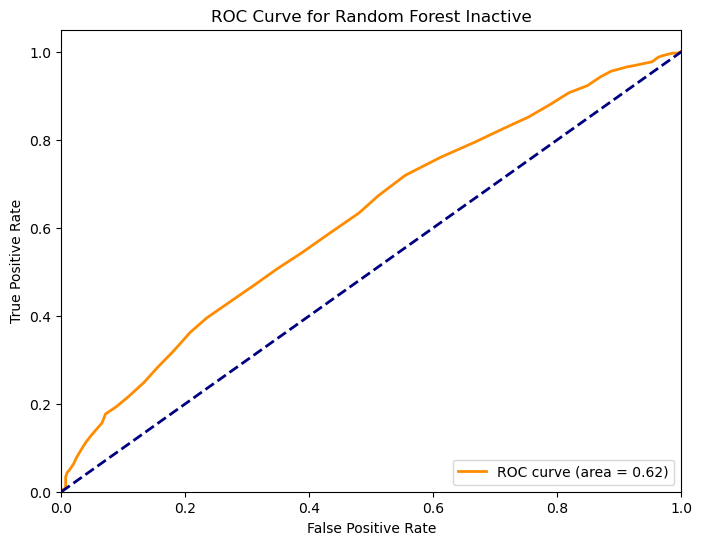

In [472]:
trainer.train_random_forest()

Classification Report for SVM Inactive:

              precision    recall  f1-score   support

           0       0.56      0.63      0.59       871
           1       0.60      0.54      0.57       922

    accuracy                           0.58      1793
   macro avg       0.58      0.58      0.58      1793
weighted avg       0.58      0.58      0.58      1793

Confusion Matrix for SVM Inactive:

[[546 325]
 [427 495]]


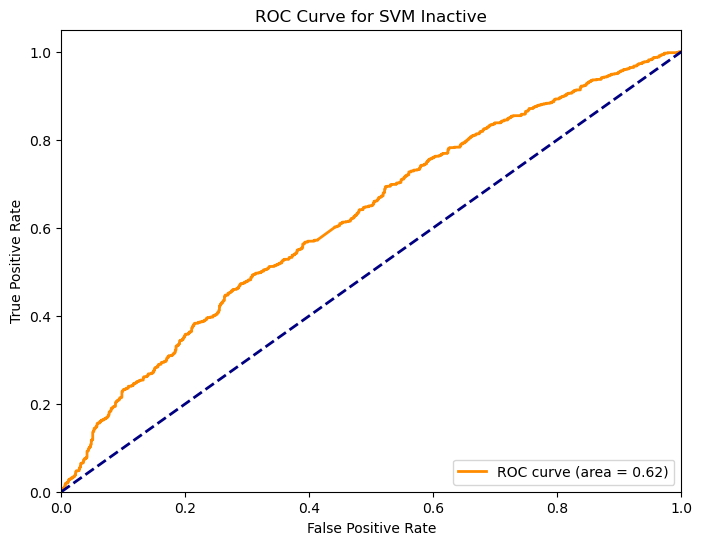

In [473]:
trainer.train_svm()

Classification Report for XGBoost Inactive:

              precision    recall  f1-score   support

           0       0.58      0.55      0.56       871
           1       0.59      0.62      0.61       922

    accuracy                           0.58      1793
   macro avg       0.58      0.58      0.58      1793
weighted avg       0.58      0.58      0.58      1793

Confusion Matrix for XGBoost Inactive:

[[477 394]
 [351 571]]


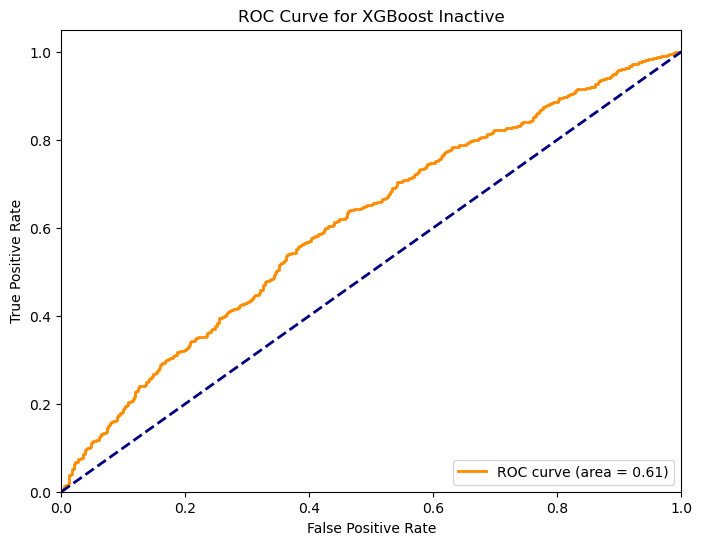

In [474]:
trainer.train_xgboost()

In [499]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-05'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-05'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-06','2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-06','2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
discount_df['avg_discount'] = discount_df[['2022-05','2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-05','2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04']].mean(axis = 1)
instance_2 = Train()
test_jun, y_jun , result_1= instance_2.train_data(test_1,test_result , cols,30)
test_result = test_result[['2022-05','2023-06','2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04']]
train_jun = instance_2.data(test_jun , test_result)
train_jun = instance_2.discount_pd(train_jun, discount_df , pd_df)
train_jun = instance_2.district(train_jun, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['actual'] = y_jun['state_m+1']
train_jun['m+2'] = y_jun['state_m+2']
train_jun['actual'] = train_jun['actual'].replace({'Active_2N':1, 'Active_1N':0 , 'Active':0})
train_jun['m+2'] = train_jun['m+2'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['month'] = 3
train_jun = train_jun.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
train_jun = train_jun[train_jun['month_new_dealer']<=20]
X_jun = train_jun.drop(['actual','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count','month_new_dealer','m+2'], axis = 1 )
X_jun= X_jun.fillna(0)
X_jun_1 = sc.fit_transform(X_jun)
loaded_model = joblib.load('Random Forest Inactive_1_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jun_1)
pred_proba = loaded_model.predict_proba(X_jun_1)[:,1]
train_jun['predicted'] = predictions
train_jun['predict_proba'] = pred_proba
df_1 = train_jun[['m+2', 'predicted']]
df_1.columns = ['actual','predicted']
result_jul = result_matrix_3[result_matrix_3['2023-05']=='Active_2N']
df_2 = result_jul[['2023-06']]
df_2['predicted'] = 1
df_2.columns = ['actual','predicted']
df_2['actual'] = df_2['actual'].replace({'Active':0,'Active_3N':1})
df_1 = pd.concat([df_1,df_2], axis = 0)
print('______MAY RESULT SVM_____','\n')
print(confusion_matrix(df_1['actual'],df_1['predicted']))
print(classification_report(df_1['actual'],df_1['predicted']))

______MAY RESULT SVM_____ 

[[ 83 295]
 [ 68 595]]
              precision    recall  f1-score   support

           0       0.55      0.22      0.31       378
           1       0.67      0.90      0.77       663

    accuracy                           0.65      1041
   macro avg       0.61      0.56      0.54      1041
weighted avg       0.63      0.65      0.60      1041



In [500]:

test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-06'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-06'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
discount_df['avg_discount'] = discount_df[['2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05']].mean(axis = 1)
instance_2 = Train()
test_jun, y_jun , result_1= instance_2.train_data(test_1,test_result , cols,31)
test_result = test_result[['2023-06','2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05']]
train_jun = instance_2.data(test_jun , test_result)
train_jun = instance_2.discount_pd(train_jun, discount_df , pd_df)
train_jun = instance_2.district(train_jun, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['actual'] = y_jun['state_m+1']
train_jun['m+2'] = y_jun['state_m+2']
train_jun['actual'] = train_jun['actual'].replace({'Active_2N':1, 'Active_1N':0 , 'Active':0})
train_jun['m+2'] = train_jun['m+2'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['month'] = 3
train_jun = train_jun.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
train_jun = train_jun[train_jun['month_new_dealer']<=20]
X_jun = train_jun.drop(['actual','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count','month_new_dealer','m+2'], axis = 1 )
X_jun= X_jun.fillna(0)
X_jun_1 = sc.fit_transform(X_jun)
loaded_model = joblib.load('SVM Inactive_1_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jun_1)
pred_proba = loaded_model.predict_proba(X_jun_1)[:,1]
train_jun['predicted'] = predictions
train_jun['predict_proba'] = pred_proba
df_1 = train_jun[['m+2', 'predicted']]
df_1.columns = ['actual','predicted']
result_jul = result_matrix_3[result_matrix_3['2023-06']=='Active_2N']
df_2 = result_jul[['2023-07']]
df_2['predicted'] = 1
df_2.columns = ['actual','predicted']
df_2['actual'] = df_2['actual'].replace({'Active':0,'Active_3N':1})
df_1 = pd.concat([df_1,df_2], axis = 0)
print('______JUN RESULT SVM_____','\n')
print(confusion_matrix(df_1['actual'],df_1['predicted']))
print(classification_report(df_1['actual'],df_1['predicted']))

______JUN RESULT SVM_____ 

[[189 199]
 [121 476]]
              precision    recall  f1-score   support

           0       0.61      0.49      0.54       388
           1       0.71      0.80      0.75       597

    accuracy                           0.68       985
   macro avg       0.66      0.64      0.64       985
weighted avg       0.67      0.68      0.67       985



In [477]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-06'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-06'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
discount_df['avg_discount'] = discount_df[['2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05']].mean(axis = 1)
instance_2 = Train()
test_jun, y_jun , result_1= instance_2.train_data(test_1,test_result , cols,31)
test_result = test_result[['2023-06','2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05']]
train_jun = instance_2.data(test_jun , test_result)
train_jun = instance_2.discount_pd(train_jun, discount_df , pd_df)
train_jun = instance_2.district(train_jun, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['actual'] = y_jun['state_m+1']
train_jun['m+2'] = y_jun['state_m+2']
train_jun['actual'] = train_jun['actual'].replace({'Active_2N':1, 'Active_1N':0 , 'Active':0})
train_jun['m+2'] = train_jun['m+2'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['month'] = 3
train_jun = train_jun.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
train_jun = train_jun[train_jun['month_new_dealer']<=20]
X_jun = train_jun.drop(['actual','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count','month_new_dealer','m+2'], axis = 1 )
X_jun= X_jun.fillna(0)
X_jun_1 = sc.fit_transform(X_jun)
loaded_model = joblib.load('XGBoost Inactive_1_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jun_1)
pred_proba = loaded_model.predict_proba(X_jun_1)[:,1]
train_jun['predicted'] = predictions
train_jun['predict_proba'] = pred_proba
df_1 = train_jun[['m+2', 'predicted']]
df_1.columns = ['actual','predicted']
result_jul = result_matrix_3[result_matrix_3['2023-06']=='Active_2N']
df_2 = result_jul[['2023-07']]
df_2['predicted'] = 1
df_2.columns = ['actual','predicted']
df_2['actual'] = df_2['actual'].replace({'Active':0,'Active_3N':1})
df_1 = pd.concat([df_1,df_2], axis = 0)
print('______JUN RESULT XGBOOST_____','\n')
print(confusion_matrix(df_1['actual'],df_1['predicted']))
print(classification_report(df_1['actual'],df_1['predicted']))

______JUN RESULT XGBOOST_____ 

[[103 285]
 [ 48 549]]
              precision    recall  f1-score   support

           0       0.68      0.27      0.38       388
           1       0.66      0.92      0.77       597

    accuracy                           0.66       985
   macro avg       0.67      0.59      0.57       985
weighted avg       0.67      0.66      0.62       985



In [478]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-06'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-06'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
discount_df['avg_discount'] = discount_df[['2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05']].mean(axis = 1)
instance_2 = Train()
test_jun, y_jun , result_1= instance_2.train_data(test_1,test_result , cols,31)
test_result = test_result[['2023-06','2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05']]
train_jun = instance_2.data(test_jun , test_result)
train_jun = instance_2.discount_pd(train_jun, discount_df , pd_df)
train_jun = instance_2.district(train_jun, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['actual'] = y_jun['state_m+1']
train_jun['m+2'] = y_jun['state_m+2']
train_jun['actual'] = train_jun['actual'].replace({'Active_2N':1, 'Active_1N':0 , 'Active':0})
train_jun['m+2'] = train_jun['m+2'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['month'] = 3
train_jun = train_jun.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
train_jun = train_jun[train_jun['month_new_dealer']<=20]
X_jun = train_jun.drop(['actual','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count','month_new_dealer','m+2'], axis = 1 )
X_jun= X_jun.fillna(0)
X_jun_1 = sc.fit_transform(X_jun)
loaded_model = joblib.load('Random Forest Inactive_1_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jun_1)
pred_proba = loaded_model.predict_proba(X_jun_1)[:,1]
train_jun['predicted'] = predictions
train_jun['predict_proba'] = pred_proba
df_1 = train_jun[['m+2', 'predicted']]
df_1.columns = ['actual','predicted']
result_jul = result_matrix_3[result_matrix_3['2023-06']=='Active_2N']
df_2 = result_jul[['2023-07']]
df_2['predicted'] = 1
df_2.columns = ['actual','predicted']
df_2['actual'] = df_2['actual'].replace({'Active':0,'Active_3N':1})
df_1 = pd.concat([df_1,df_2], axis = 0)
print('______JUN RESULT RF_____','\n')
print(confusion_matrix(df_1['actual'],df_1['predicted']))
print(classification_report(df_1['actual'],df_1['predicted']))

______JUN RESULT RF_____ 

[[101 287]
 [ 45 552]]
              precision    recall  f1-score   support

           0       0.69      0.26      0.38       388
           1       0.66      0.92      0.77       597

    accuracy                           0.66       985
   macro avg       0.67      0.59      0.57       985
weighted avg       0.67      0.66      0.61       985



In [479]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-07'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-07'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = [ '2023-08','2023-09','2023-10']
test_1 = test.drop([ '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
discount_df['avg_discount'] = discount_df[[ '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06']].mean(axis = 1)
instance_2 = Train()
test_jul, y_jul , result_1= instance_2.train_data(test_1,test_result , cols,32)
test_result = test_result[['2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06']]
test_result.columns = list(result_1.columns)[::-1]
train_jul = instance_2.data(test_jul , test_result)
train_jul = instance_2.discount_pd(train_jul, discount_df , pd_df)
train_jul = instance_2.district(train_jul, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jul['actual'] = y_jul['state_m+1']
train_jul['m+2'] = y_jul['state_m+2']
train_jul['actual'] = train_jul['actual'].replace({'Active_2N':1, 'Active_1N':0 , 'Active':0})
train_jul['m+2'] = train_jul['m+2'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jul['month'] = 4
train_jul = train_jul.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
train_jul = train_jul[train_jul['month_new_dealer']<=21]
X_jul = train_jul.drop(['actual','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count','month_new_dealer','m+2'], axis = 1 )
X_jul= X_jul.fillna(0)
X_jul_1 = sc.fit_transform(X_jul)
loaded_model = joblib.load('SVM Inactive_1_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jul_1)
pred_proba = loaded_model.predict_proba(X_jul_1)[:,1]
train_jul['predicted'] = predictions
train_jul['predict_proba'] = pred_proba
df_1 = train_jul[['m+2', 'predicted']]
df_1.columns = ['actual','predicted']
result_jul = result_matrix_3[result_matrix_3['2023-07']=='Active_2N']
df_2 = result_jul[['2023-08']]
df_2['predicted'] = 1
df_2.columns = ['actual','predicted']
df_2['actual'] = df_2['actual'].replace({'Active':0,'Active_3N':1})
df_1 = pd.concat([df_1,df_2], axis = 0)
print('______JUL RESULT SVM_____','\n')
print(confusion_matrix(df_1['actual'],df_1['predicted']))
print(classification_report(df_1['actual'],df_1['predicted']))

______JUL RESULT SVM_____ 

[[245 209]
 [130 479]]
              precision    recall  f1-score   support

           0       0.65      0.54      0.59       454
           1       0.70      0.79      0.74       609

    accuracy                           0.68      1063
   macro avg       0.67      0.66      0.66      1063
weighted avg       0.68      0.68      0.68      1063



In [480]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-07'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-07'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = [ '2023-08','2023-09','2023-10']
test_1 = test.drop([ '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
discount_df['avg_discount'] = discount_df[[ '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06']].mean(axis = 1)
instance_2 = Train()
test_jul, y_jul , result_1= instance_2.train_data(test_1,test_result , cols,32)
test_result = test_result[['2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06']]
test_result.columns = list(result_1.columns)[::-1]
train_jul = instance_2.data(test_jul , test_result)
train_jul = instance_2.discount_pd(train_jul, discount_df , pd_df)
train_jul = instance_2.district(train_jul, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jul['actual'] = y_jul['state_m+1']
train_jul['m+2'] = y_jul['state_m+2']
train_jul['actual'] = train_jul['actual'].replace({'Active_2N':1, 'Active_1N':0 , 'Active':0})
train_jul['m+2'] = train_jul['m+2'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jul['month'] = 4
train_jul = train_jul.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
train_jul = train_jul[train_jul['month_new_dealer']<=21]
X_jul = train_jul.drop(['actual','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count','month_new_dealer','m+2'], axis = 1 )
X_jul= X_jul.fillna(0)
X_jul_1 = sc.fit_transform(X_jul)
loaded_model = joblib.load('XGBoost Inactive_1_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jul_1)
pred_proba = loaded_model.predict_proba(X_jul_1)[:,1]
train_jul['predicted'] = predictions
train_jul['predict_proba'] = pred_proba
df_1 = train_jul[['m+2', 'predicted']]
df_1.columns = ['actual','predicted']
result_jul = result_matrix_3[result_matrix_3['2023-07']=='Active_2N']
df_2 = result_jul[['2023-08']]
df_2['predicted'] = 1
df_2.columns = ['actual','predicted']
df_2['actual'] = df_2['actual'].replace({'Active':0,'Active_3N':1})
df_1 = pd.concat([df_1,df_2], axis = 0)
print('______JUL RESULT XGBOOST_____','\n')
print(confusion_matrix(df_1['actual'],df_1['predicted']))
print(classification_report(df_1['actual'],df_1['predicted']))

______JUL RESULT XGBOOST_____ 

[[136 318]
 [ 70 539]]
              precision    recall  f1-score   support

           0       0.66      0.30      0.41       454
           1       0.63      0.89      0.74       609

    accuracy                           0.63      1063
   macro avg       0.64      0.59      0.57      1063
weighted avg       0.64      0.63      0.60      1063



In [481]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-07'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-07'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = [ '2023-08','2023-09','2023-10']
test_1 = test.drop([ '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
discount_df['avg_discount'] = discount_df[[ '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06']].mean(axis = 1)
instance_2 = Train()
test_jul, y_jul , result_1= instance_2.train_data(test_1,test_result , cols,32)
test_result = test_result[['2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06']]
test_result.columns = list(result_1.columns)[::-1]
train_jul = instance_2.data(test_jul , test_result)
train_jul = instance_2.discount_pd(train_jul, discount_df , pd_df)
train_jul = instance_2.district(train_jul, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jul['actual'] = y_jul['state_m+1']
train_jul['m+2'] = y_jul['state_m+2']
train_jul['actual'] = train_jul['actual'].replace({'Active_2N':1, 'Active_1N':0 , 'Active':0})
train_jul['m+2'] = train_jul['m+2'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jul['month'] = 4
train_jul = train_jul.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
train_jul = train_jul[train_jul['month_new_dealer']<=21]
X_jul = train_jul.drop(['actual','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count','month_new_dealer','m+2'], axis = 1 )
X_jul= X_jul.fillna(0)
X_jul_1 = sc.fit_transform(X_jul)
loaded_model = joblib.load('Random Forest Inactive_1_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jul_1)
pred_proba = loaded_model.predict_proba(X_jul_1)[:,1]
train_jul['predicted'] = predictions
train_jul['predict_proba'] = pred_proba
df_1 = train_jul[['m+2', 'predicted']]
df_1.columns = ['actual','predicted']
result_jul = result_matrix_3[result_matrix_3['2023-07']=='Active_2N']
df_2 = result_jul[['2023-08']]
df_2['predicted'] = 1
df_2.columns = ['actual','predicted']
df_2['actual'] = df_2['actual'].replace({'Active':0,'Active_3N':1})
df_1 = pd.concat([df_1,df_2], axis = 0)
print('______JUL RESULT RF_____','\n')
print(confusion_matrix(df_1['actual'],df_1['predicted']))
print(classification_report(df_1['actual'],df_1['predicted']))

______JUL RESULT RF_____ 

[[125 329]
 [ 72 537]]
              precision    recall  f1-score   support

           0       0.63      0.28      0.38       454
           1       0.62      0.88      0.73       609

    accuracy                           0.62      1063
   macro avg       0.63      0.58      0.56      1063
weighted avg       0.63      0.62      0.58      1063



In [482]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-08'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-08'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = [ '2023-09','2023-10']
test_1 = test.drop(['2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
discount_df['avg_discount'] = discount_df[[ '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06','2023-07']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06','2023-07']].mean(axis = 1)
instance_2 = Train()
test_aug, y_aug , result_1= instance_2.train_data(test_1,test_result , cols,33)
test_result = test_result[['2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
test_result.columns = list(result_1.columns)[::-1]
train_aug = instance_2.data(test_aug , test_result)
train_aug = instance_2.discount_pd(train_aug, discount_df , pd_df)
train_aug = instance_2.district(train_aug, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_aug['actual'] = y_aug['state_m+1']
train_aug['m+2'] = y_aug['state_m+2']
train_aug['actual'] = train_aug['actual'].replace({'Active_2N':1, 'Active_1N':0 , 'Active':0})
train_aug['m+2'] = train_aug['m+2'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_aug['month'] = 5
train_aug = train_aug.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
train_aug = train_aug[train_aug['month_new_dealer']<=22]
X_aug = train_aug.drop(['actual','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count','month_new_dealer','m+2'], axis = 1 )
X_aug= X_aug.fillna(0)
X_aug_1 = sc.fit_transform(X_aug)
loaded_model = joblib.load('SVM Inactive_1_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_aug_1)
pred_proba = loaded_model.predict_proba(X_aug_1)[:,1]
train_aug['predicted'] = predictions
train_aug['predict_proba'] = pred_proba
df_1 = train_aug[['m+2', 'predicted']]
df_1.columns = ['actual','predicted']
result_jul = result_matrix_3[result_matrix_3['2023-08']=='Active_2N']
df_2 = result_jul[['2023-09']]
df_2['predicted'] = 1
df_2.columns = ['actual','predicted']
df_2['actual'] = df_2['actual'].replace({'Active':0,'Active_3N':1})
df_1 = pd.concat([df_1,df_2], axis = 0)
print('______AUG RESULT SVM_____','\n')
print(confusion_matrix(df_1['actual'],df_1['predicted']))
print(classification_report(df_1['actual'],df_1['predicted']))

______AUG RESULT SVM_____ 

[[166 176]
 [125 551]]
              precision    recall  f1-score   support

           0       0.57      0.49      0.52       342
           1       0.76      0.82      0.79       676

    accuracy                           0.70      1018
   macro avg       0.66      0.65      0.65      1018
weighted avg       0.69      0.70      0.70      1018



In [486]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-08'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-08'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = [ '2023-09','2023-10']
test_1 = test.drop(['2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
discount_df['avg_discount'] = discount_df[[ '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06','2023-07']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06','2023-07']].mean(axis = 1)
instance_2 = Train()
test_aug, y_aug , result_1= instance_2.train_data(test_1,test_result , cols,33)
test_result = test_result[['2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
test_result.columns = list(result_1.columns)[::-1]
train_aug = instance_2.data(test_aug , test_result)
train_aug = instance_2.discount_pd(train_aug, discount_df , pd_df)
train_aug = instance_2.district(train_aug, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_aug['actual'] = y_aug['state_m+1']
train_aug['m+2'] = y_aug['state_m+2']
train_aug['actual'] = train_aug['actual'].replace({'Active_2N':1, 'Active_1N':0 , 'Active':0})
train_aug['m+2'] = train_aug['m+2'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_aug['month'] = 5
train_aug = train_aug.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
train_aug = train_aug[train_aug['month_new_dealer']<=22]
X_aug = train_aug.drop(['actual','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count','month_new_dealer','m+2'], axis = 1 )
X_aug= X_aug.fillna(0)
X_aug_1 = sc.fit_transform(X_aug)
loaded_model = joblib.load('XGBoost Inactive_1_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_aug_1)
pred_proba = loaded_model.predict_proba(X_aug_1)[:,1]
train_aug['predicted'] = predictions
train_aug['predict_proba'] = pred_proba
df_1 = train_aug[['m+2', 'predicted']]
df_1.columns = ['actual','predicted']
result_jul = result_matrix_3[result_matrix_3['2023-08']=='Active_2N']
df_2 = result_jul[['2023-09']]
df_2['predicted'] = 1
df_2.columns = ['actual','predicted']
df_2['actual'] = df_2['actual'].replace({'Active':0,'Active_3N':1})
df_1 = pd.concat([df_1,df_2], axis = 0)
print('______AUG RESULT SVM XGBOOST_____','\n')
print(confusion_matrix(df_1['actual'],df_1['predicted']))
print(classification_report(df_1['actual'],df_1['predicted']))

______AUG RESULT SVM XGBOOST_____ 

[[ 89 253]
 [ 70 606]]
              precision    recall  f1-score   support

           0       0.56      0.26      0.36       342
           1       0.71      0.90      0.79       676

    accuracy                           0.68      1018
   macro avg       0.63      0.58      0.57      1018
weighted avg       0.66      0.68      0.64      1018



In [489]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-08'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-08'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = [ '2023-09','2023-10']
test_1 = test.drop(['2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
discount_df['avg_discount'] = discount_df[[ '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06','2023-07']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06','2023-07']].mean(axis = 1)
instance_2 = Train()
test_aug, y_aug , result_1= instance_2.train_data(test_1,test_result , cols,33)
test_result = test_result[['2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07']]
test_result.columns = list(result_1.columns)[::-1]
train_aug = instance_2.data(test_aug , test_result)
train_aug = instance_2.discount_pd(train_aug, discount_df , pd_df)
train_aug = instance_2.district(train_aug, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_aug['actual'] = y_aug['state_m+1']
train_aug['m+2'] = y_aug['state_m+2']
train_aug['actual'] = train_aug['actual'].replace({'Active_2N':1, 'Active_1N':0 , 'Active':0})
train_aug['m+2'] = train_aug['m+2'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_aug['month'] = 5
train_aug = train_aug.merge(pivot_3['month_new_dealer'], left_index = True , right_index = True , how = 'inner')
train_aug = train_aug[train_aug['month_new_dealer']<=22]
X_aug = train_aug.drop(['actual','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count','month_new_dealer','m+2'], axis = 1 )
X_aug= X_aug.fillna(0)
X_aug_1 = sc.fit_transform(X_aug)
loaded_model = joblib.load('Random Forest Inactive_1_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_aug_1)
pred_proba = loaded_model.predict_proba(X_aug_1)[:,1]
train_aug['predicted'] = predictions
train_aug['predict_proba'] = pred_proba
df_1 = train_aug[['m+2', 'predicted']]
df_1.columns = ['actual','predicted']
result_jul = result_matrix_3[result_matrix_3['2023-08']=='Active_2N']
df_2 = result_jul[['2023-09']]
df_2['predicted'] = 1
df_2.columns = ['actual','predicted']
df_2['actual'] = df_2['actual'].replace({'Active':0,'Active_3N':1})
df_1 = pd.concat([df_1,df_2], axis = 0)
print('______AUG RESULT RF_____','\n')
print(confusion_matrix(df_1['actual'],df_1['predicted']))
print(classification_report(df_1['actual'],df_1['predicted']))

______AUG RESULT RF_____ 

[[ 85 257]
 [ 64 612]]
              precision    recall  f1-score   support

           0       0.57      0.25      0.35       342
           1       0.70      0.91      0.79       676

    accuracy                           0.68      1018
   macro avg       0.64      0.58      0.57      1018
weighted avg       0.66      0.68      0.64      1018



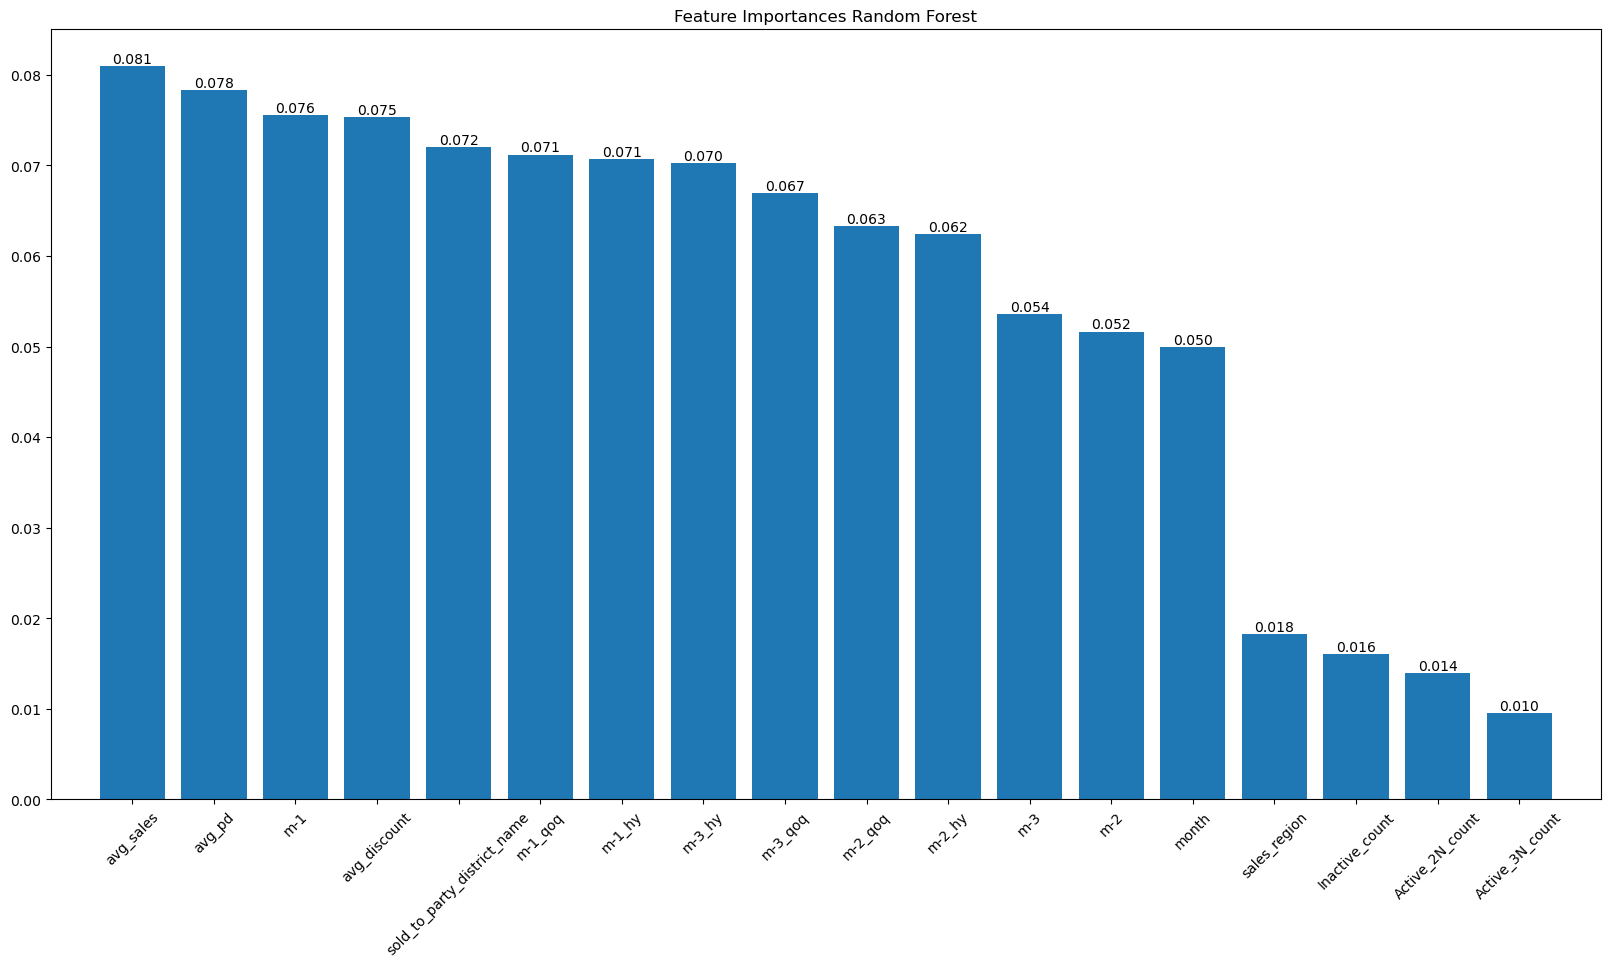

In [490]:
importances = loaded_model.feature_importances_
feature_names = X_aug.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20, 10))
plt.title("Feature Importances Random Forest")
bars = plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlim([-1, X.shape[1]])

# Add annotations for feature importance values on the bars
for bar, importance in zip(bars, importances[indices]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{importance:.3f}", ha='center', va='bottom')

plt.show()

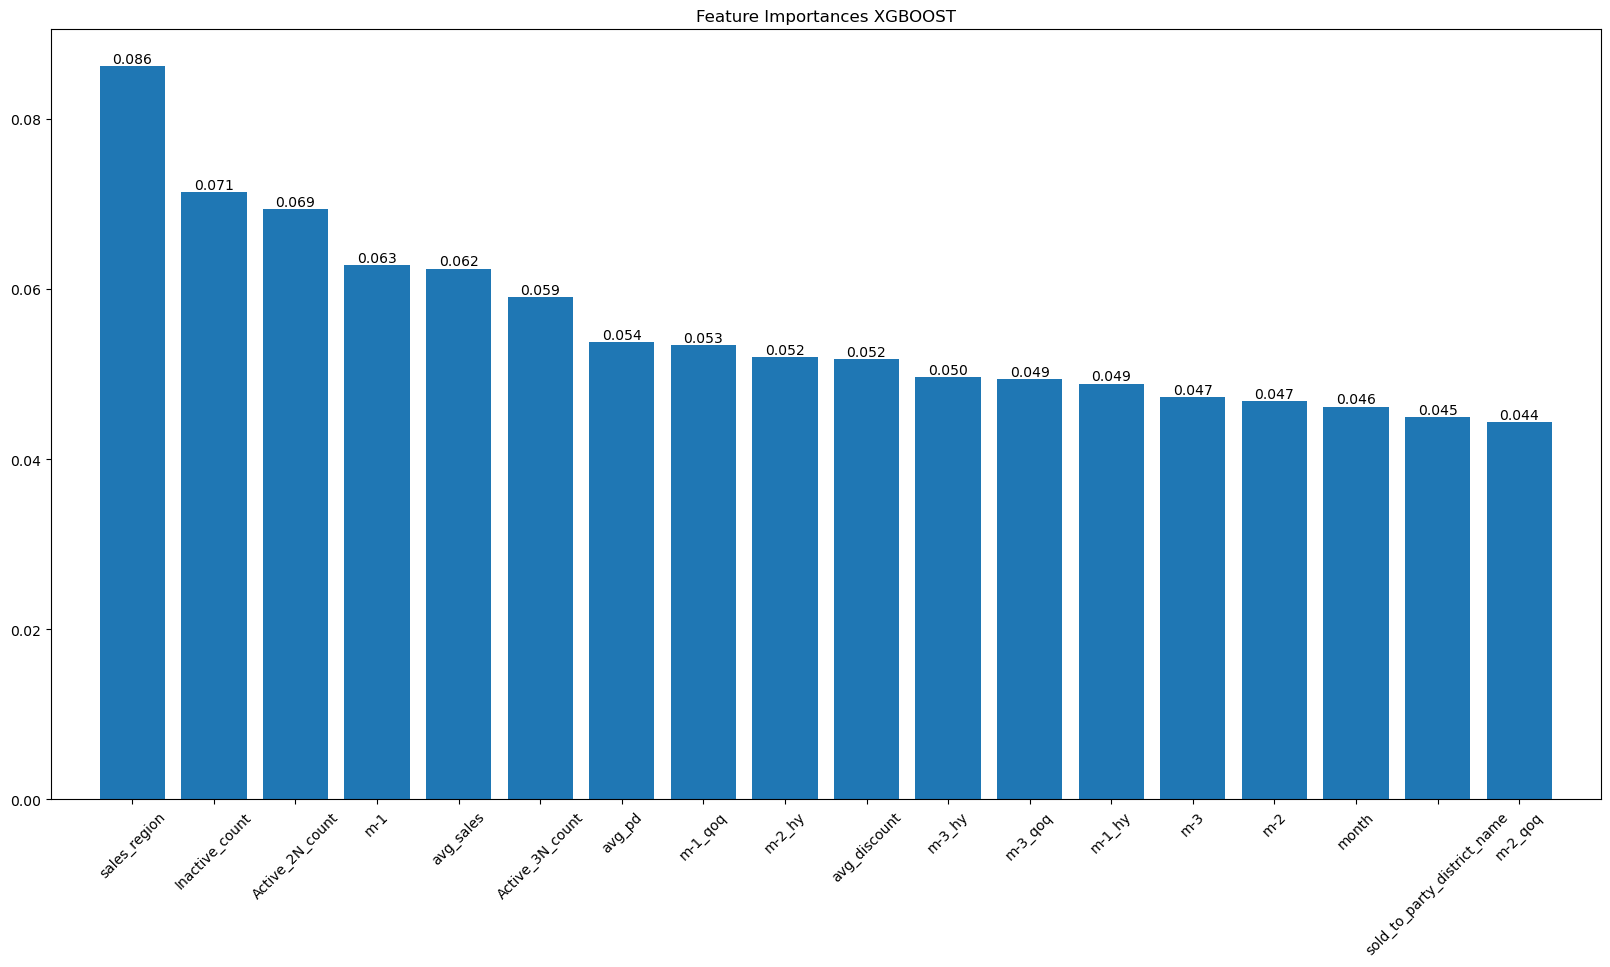

In [488]:
importances = loaded_model.feature_importances_
feature_names = X_aug.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20, 10))
plt.title("Feature Importances XGBOOST")
bars = plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlim([-1, X.shape[1]])

# Add annotations for feature importance values on the bars
for bar, importance in zip(bars, importances[indices]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{importance:.3f}", ha='center', va='bottom')

plt.show()

In [493]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

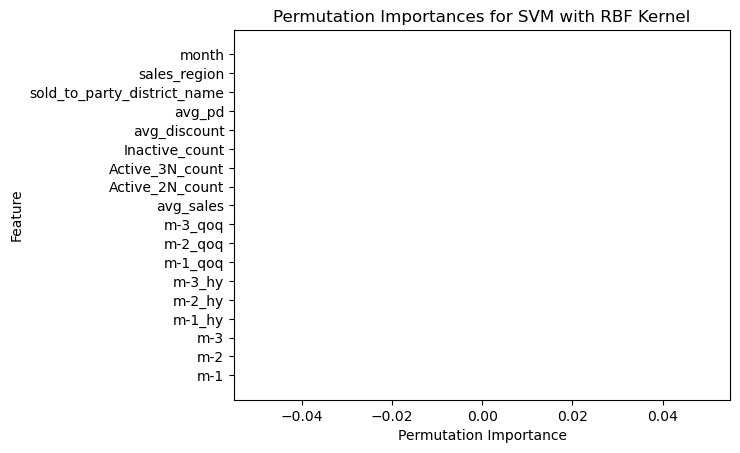

In [494]:
from sklearn.inspection import permutation_importance
loaded_model = joblib.load('SVM Inactive_1_model.pkl')
result = permutation_importance(loaded_model, X_test, y_test, n_repeats=30, random_state=42)
# Get feature importances
importances = result.importances_mean

# Get feature names from the iris dataset
feature_names = X.columns

# Plot the feature importances
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances for SVM with RBF Kernel')
plt.show()

In [517]:
discount_24

,Unnamed: 0,Cus Code,Month,Total Discount,PD
0,0,7000004,2023-04,24662.46,5750.00
1,1,7000004,2023-05,23159.94,9999.94
2,2,7000004,2023-06,39901.10,2265.58
3,3,7000004,2023-07,35774.98,21874.98
4,4,7000004,2023-08,10800.00,NaN
...,...,...,...,...,...
46083,46083,7041791,2023-08,3500.00,NaN
46084,46084,7041792,2023-08,4945.00,NaN
46085,46085,7041793,2023-08,800.00,NaN
46086,46086,7041815,2023-08,1600.00,NaN


NameError: name 'discount_df' is not defined